# Clustering Algorithms Evaluation

In [1]:
# libraries for data handling and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to normalize RSSI values before clustering
from sklearn.preprocessing import StandardScaler

# to evaluate clustering quality, especially when selecting the best number of clusters (k).
from sklearn.metrics import silhouette_score

# for DBSCAN and visualization (dimensionality reduction to reduce noise and sparsity in high-dimensional fingerprint vectors).
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# to draw visual cluster boundaries (ConvexHull)
from scipy.spatial import ConvexHull, QhullError

import time
from common_functions import read_fingerprint_data

In [2]:
def visualize_clusters_on_floorplan(df_train, floorplan_path, title="Clustering Overlay"):
    floor = plt.imread(floorplan_path)
    n_clusters = len(set(df_train['cluster'])) - (1 if -1 in df_train['cluster'].unique() else 0)
    centroids = df_train.groupby('cluster')[['x', 'y']].mean()
    labels = sorted(df_train['cluster'].unique())
    cmap = plt.get_cmap('tab10' if n_clusters <= 10 else 'tab20', len(labels))
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(floor, origin='upper')
    ax.axis('off')
    for label in labels:
        cluster_pts = df_train[df_train['cluster'] == label][['x', 'y']].values
        color = 'lightgray' if label == -1 else cmap(int(label) % cmap.N)
        label_name = 'noise' if label == -1 else f'Cluster {label}'
        ax.scatter(cluster_pts[:, 0], cluster_pts[:, 1], c=[color], s=30, label=label_name)
        if label != -1 and len(cluster_pts) >= 3:
            try:
                hull = ConvexHull(cluster_pts)
                hull_pts = cluster_pts[hull.vertices]
                ax.fill(hull_pts[:, 0], hull_pts[:, 1], facecolor=color, alpha=0.2, edgecolor='k')
            except QhullError:
                pass
    ax.scatter(centroids['x'], centroids['y'], c='black', s=100, marker='X', label='Centroid')
    ax.set_title(title)
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()

def plot_clusters_inline(df_train, floorplan_path, title="Cluster Overlay (Inline Version)"):
    floorplan_img = plt.imread(floorplan_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(floorplan_img, origin='upper')
    plt.axis('off')
    unique_clusters = sorted(df_train['cluster'].unique())
    colors = plt.cm.get_cmap('tab10', len(unique_clusters))
    for i, cid in enumerate(unique_clusters):
        points = df_train[df_train['cluster'] == cid]
        color = 'lightgray' if cid == -1 else colors(i)
        label = 'Noise' if cid == -1 else f"Cluster {cid}"
        plt.scatter(points['x'], points['y'], s=60, label=label, color=color, alpha=0.8)
    centroids = df_train.groupby('cluster')[['x', 'y']].mean()
    plt.scatter(centroids['x'], centroids['y'], c='black', s=150, marker='X', label='Centroid')
    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()


In [3]:
def fingerprint_to_dataframe(fp_dict):
    rows = []
    for key, rssi in fp_dict.items():
        x, y = map(int, key.split('_'))
        filtered = {b: r for b, r in rssi.items() if b[:14] in ALLOWED_PREFIXES}
        row = {'x': x, 'y': y}
        row.update(filtered)
        rows.append(row)
    return pd.DataFrame(rows).fillna(-100)

In [4]:
# --- Allowed AP prefixes on first floor ---
ALLOWED_PREFIXES = {
    '70:b3:17:8d:e9', '70:b3:17:8e:1c', '78:bc:1a:37:7e',
    '48:8b:0a:ca:a8', '48:8b:0a:cb:67', '48:8b:0a:cb:69'
}

In [5]:
# 1. Load & preprocess
fp_dict = read_fingerprint_data('fpData-Full.txt')
df = fingerprint_to_dataframe(fp_dict)

# collapse BSSIDs into prefix-columns
bssid_cols = [c for c in df.columns if c not in ('x', 'y')]
prefixes = sorted({c[:14] for c in bssid_cols})
for p in prefixes:
    df[p] = df[bssid_cols].filter(like=p).max(axis=1)
df.drop(columns=bssid_cols, inplace=True)

# features + scaling
features = df[prefixes].values
scaler = StandardScaler().fit(features)
X = scaler.transform(features)

In [6]:
df.head()

,x,y,48:8b:0a:ca:a8,48:8b:0a:cb:67,48:8b:0a:cb:69,70:b3:17:8d:e9,70:b3:17:8e:1c,78:bc:1a:37:7e
0,1286,858,-37.0,-80.0,-79.0,-100.0,-87.0,-66.0
1,526,1111,-86.0,-82.0,-100.0,-73.0,-38.0,-85.0
2,793,371,-73.0,-40.0,-82.0,-100.0,-74.0,-87.0
3,1220,912,-41.0,-91.0,-89.0,-100.0,-80.0,-56.0
4,1256,912,-41.0,-91.0,-89.0,-100.0,-84.0,-56.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x               1131 non-null   int64  
 1   y               1131 non-null   int64  
 2   48:8b:0a:ca:a8  1131 non-null   float64
 3   48:8b:0a:cb:67  1131 non-null   float64
 4   48:8b:0a:cb:69  1131 non-null   float64
 5   70:b3:17:8d:e9  1131 non-null   float64
 6   70:b3:17:8e:1c  1131 non-null   float64
 7   78:bc:1a:37:7e  1131 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 70.8 KB


In [8]:
results = []
k_range = range(2, 21)

C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\saleh\Anaconda3\envs\ml_env\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\saleh\Anaconda3\envs\ml_env\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\saleh\Anaconda3\envs\ml_env\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(exec

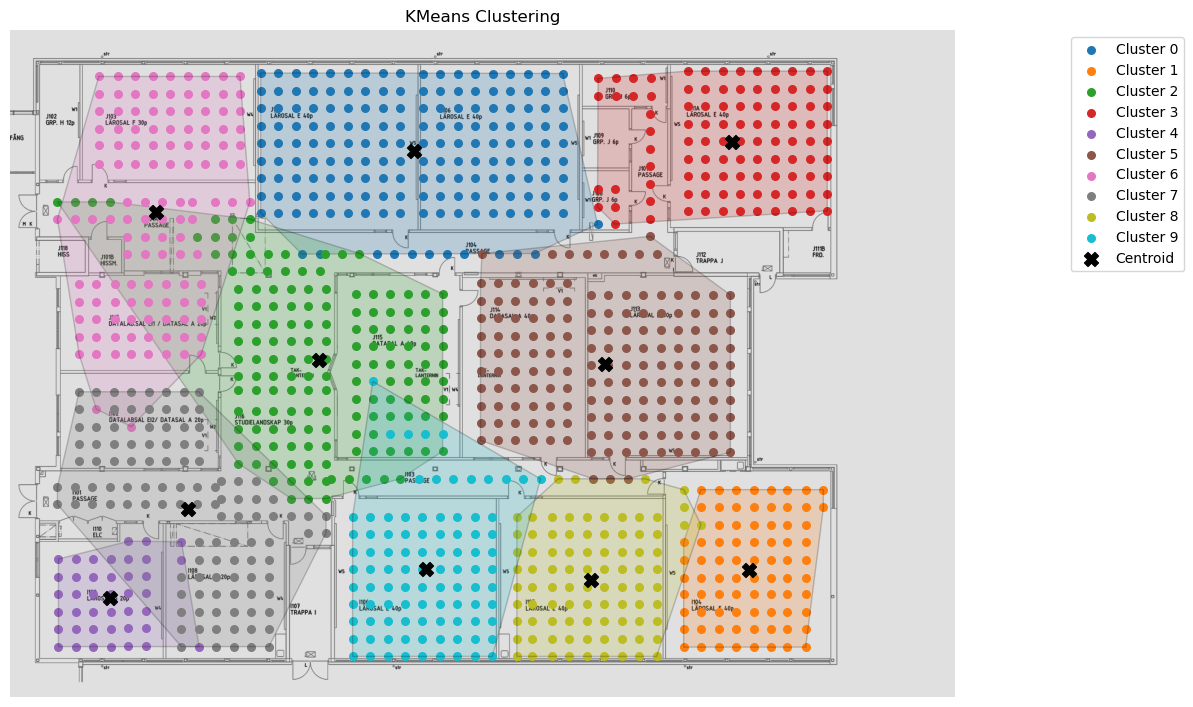

C:\Users\saleh\AppData\Local\Temp\ipykernel_18544\70227659.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


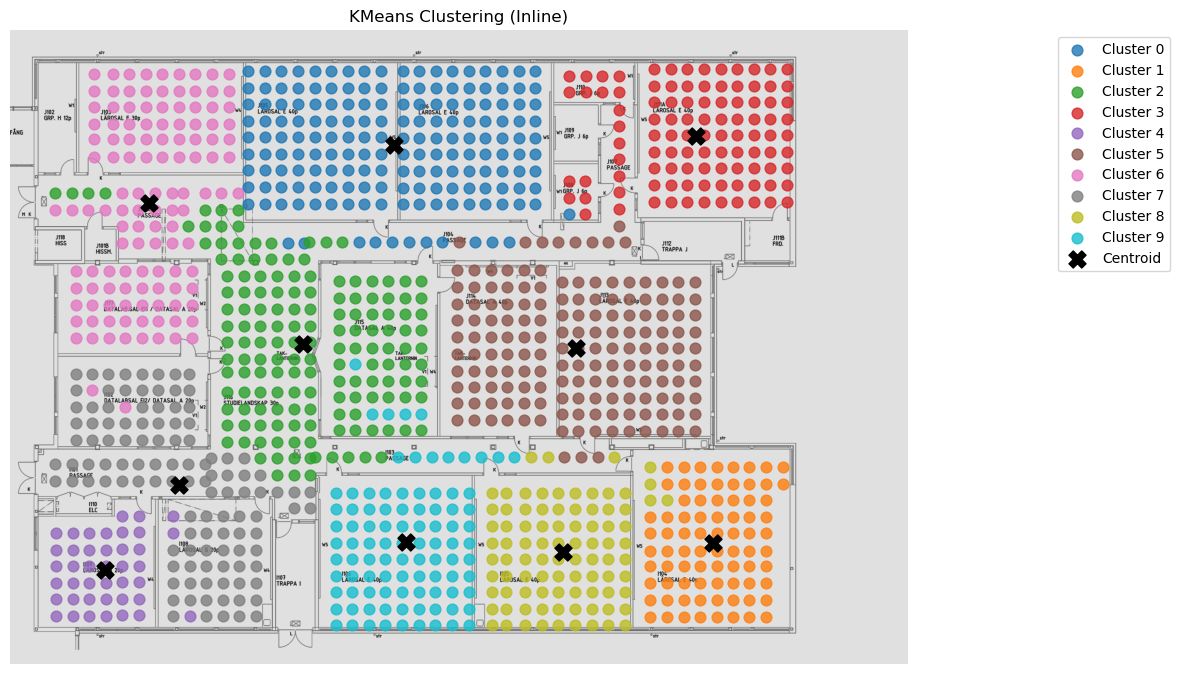

In [9]:
# --- KMeans ---
best_k, best_score = 2, -1.0
for k in k_range:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X)
    s = silhouette_score(X, labels)
    if s > best_score:
        best_k, best_score = k, s

start = time.time()
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X)
end = time.time()
results.append({
    'Algorithm': 'KMeans',
    'Clusters': best_k,
    'Clustering Time (s)': round(end - start, 4),
    'Silhouette Score': round(silhouette_score(X, kmeans.labels_), 4)
})

kmeans_labels = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(X)
df_train = df.copy()
df_train['cluster'] = kmeans_labels
visualize_clusters_on_floorplan(df_train, "images/HV I-J Plan 1.png", "KMeans Clustering")
plot_clusters_inline(df_train, "images/HV I-J Plan 1.png", title="KMeans Clustering (Inline)")

In [10]:
len(kmeans.cluster_centers_)

10

C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

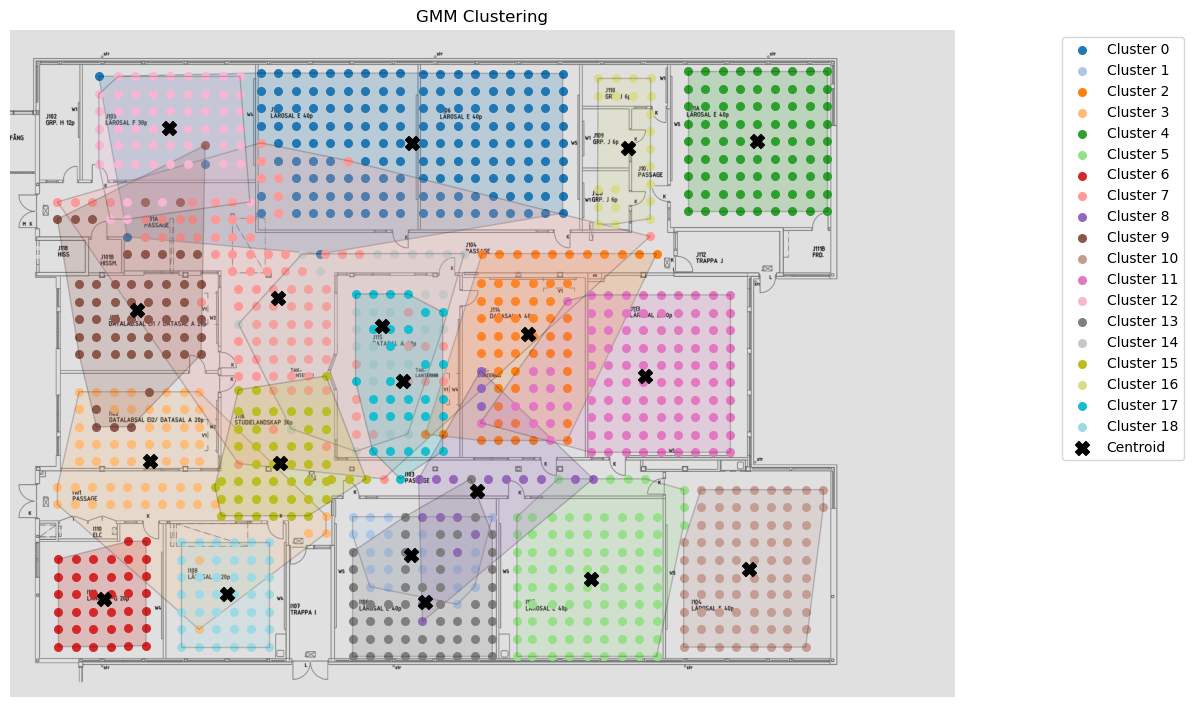

C:\Users\saleh\AppData\Local\Temp\ipykernel_18544\70227659.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


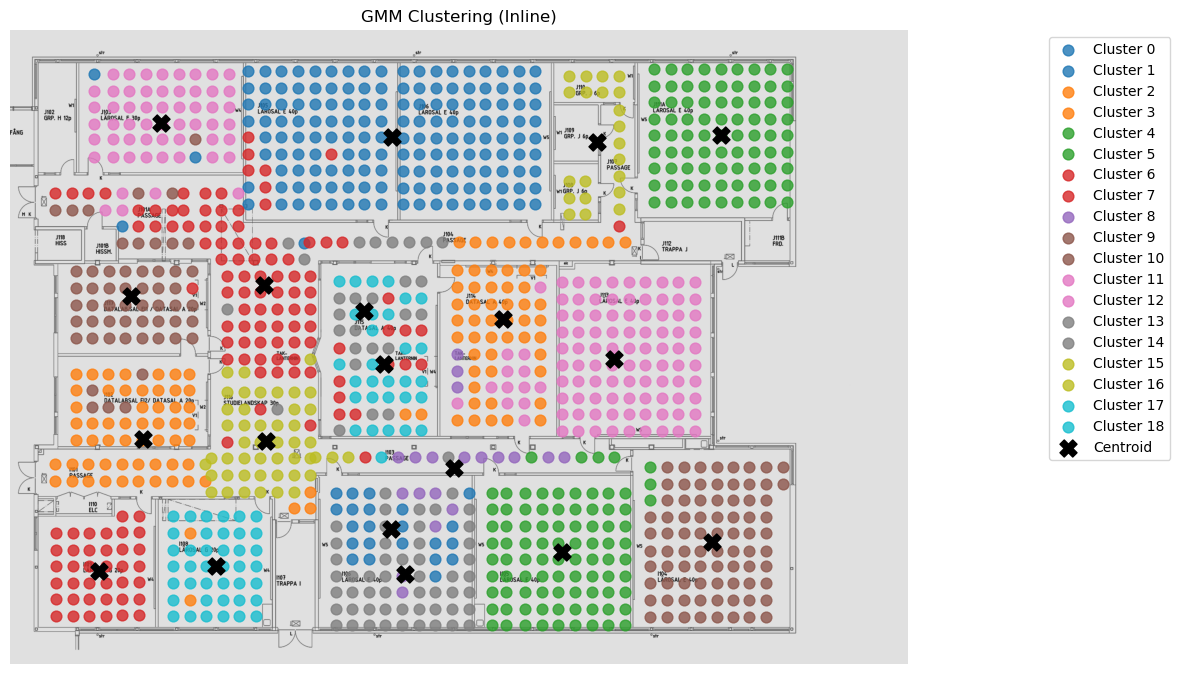

In [11]:
# --- GMM ---
best_k, best_bic = 2, np.inf
for k in k_range:
    gm = GaussianMixture(n_components=k, covariance_type='diag', reg_covar=1e-3, random_state=42).fit(X)
    bic = gm.bic(X)
    if bic < best_bic:
        best_bic, best_k = bic, k

start = time.time()
gmm = GaussianMixture(n_components=best_k, covariance_type='diag', reg_covar=1e-3, random_state=42).fit(X)
end = time.time()
gmm_labels = gmm.predict(X)
s = silhouette_score(X, gmm_labels) if len(set(gmm_labels)) > 1 else -1.0
results.append({
    'Algorithm': 'GMM',
    'Clusters': best_k,
    'Clustering Time (s)': round(end - start, 4),
    'Silhouette Score': round(s, 4)
})

gmm_labels = GaussianMixture(n_components=best_k, covariance_type='diag', reg_covar=1e-3, random_state=42).fit_predict(X)
df_train['cluster'] = gmm_labels
visualize_clusters_on_floorplan(df_train, "images/HV I-J Plan 1.png", "GMM Clustering")
plot_clusters_inline(df_train, "images/HV I-J Plan 1.png", title="GMM Clustering (Inline)")

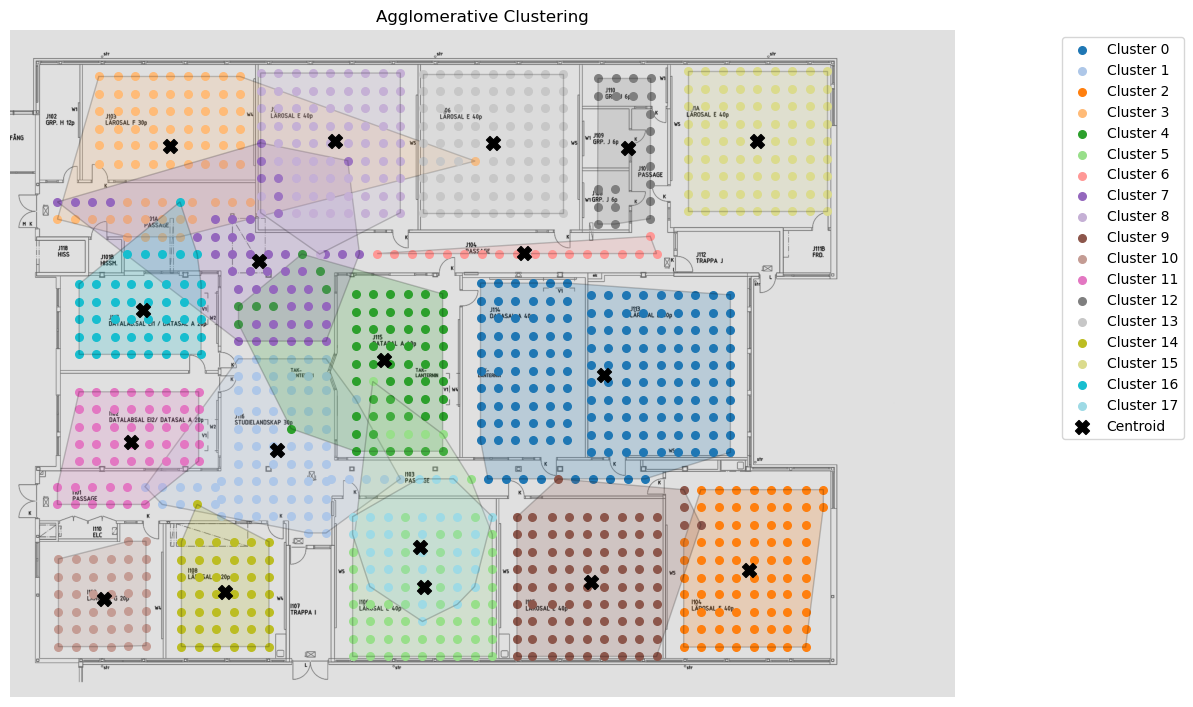

C:\Users\saleh\AppData\Local\Temp\ipykernel_18544\70227659.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


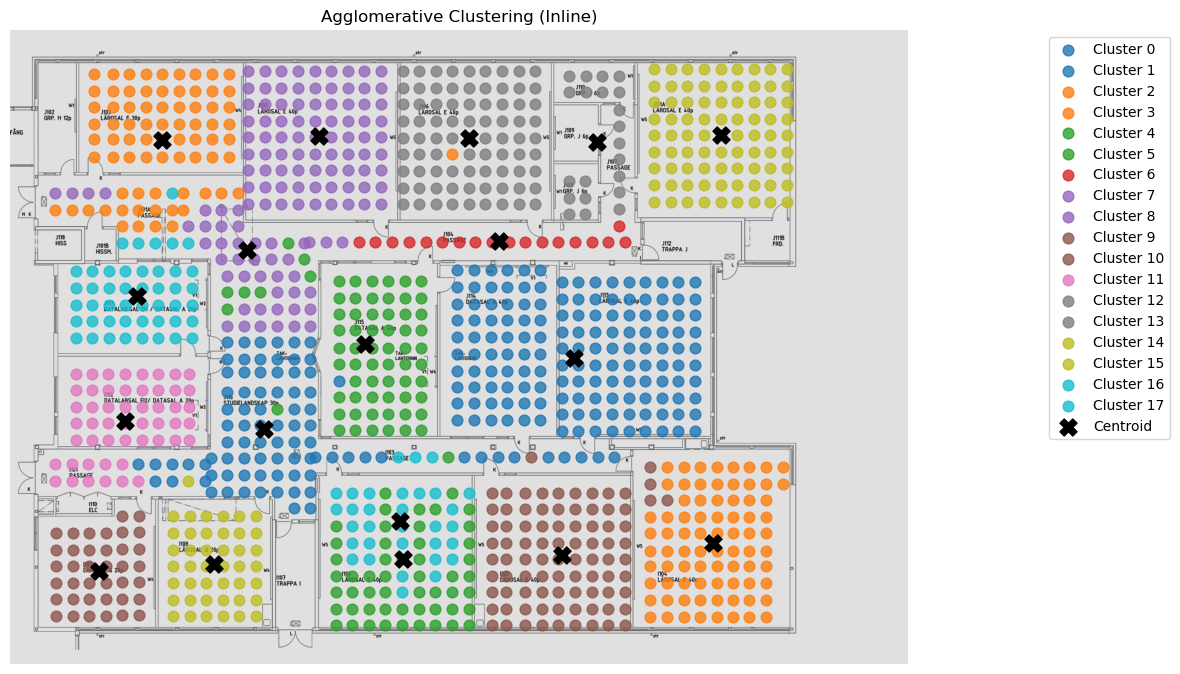

In [12]:
# --- Agglomerative ---
best_k, best_score = 2, -1.0
for k in k_range:
    labels = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    s = silhouette_score(X, labels)
    if s > best_score:
        best_k, best_score = k, s

start = time.time()
agg = AgglomerativeClustering(n_clusters=best_k).fit(X)
end = time.time()
results.append({
    'Algorithm': 'Agglomerative',
    'Clusters': best_k,
    'Clustering Time (s)': round(end - start, 4),
    'Silhouette Score': round(silhouette_score(X, agg.labels_), 4)
})

agglomerative_labels = AgglomerativeClustering(n_clusters=best_k).fit_predict(X)
df_train['cluster'] = agglomerative_labels
visualize_clusters_on_floorplan(df_train, "images/HV I-J Plan 1.png", "Agglomerative Clustering")
plot_clusters_inline(df_train, "images/HV I-J Plan 1.png", title="Agglomerative Clustering (Inline)")

DBSCAN best eps=0.8 with silhouette=0.1429


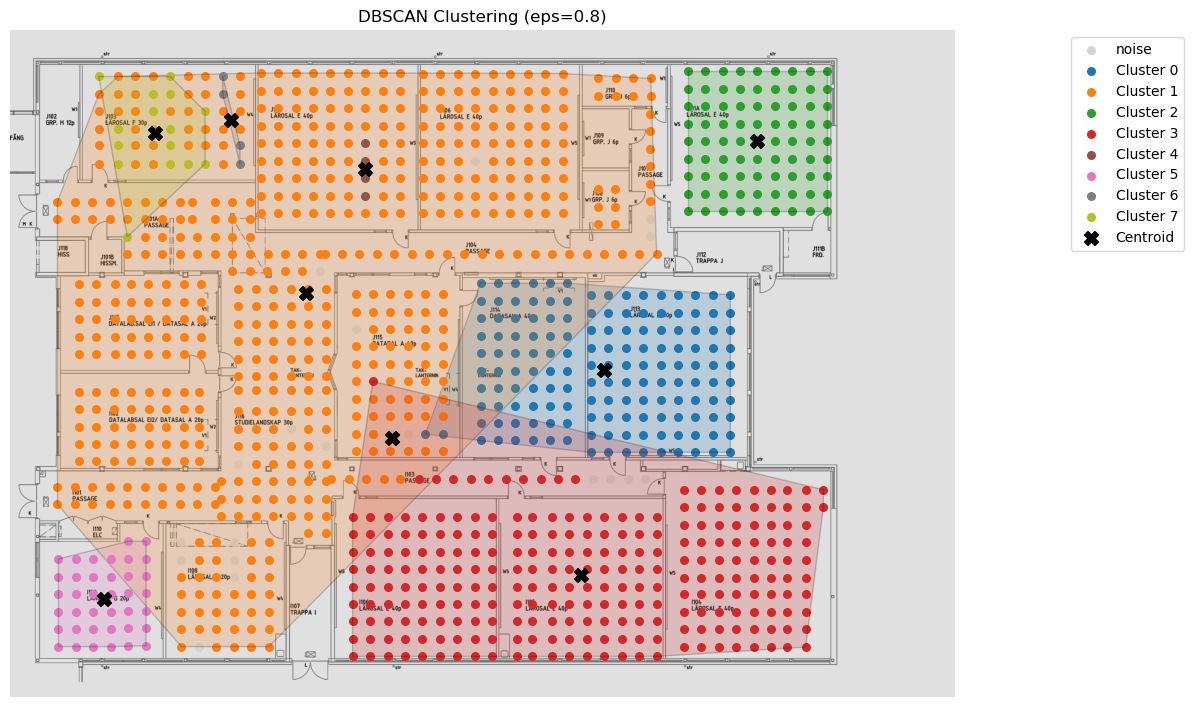

C:\Users\saleh\AppData\Local\Temp\ipykernel_18544\70227659.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


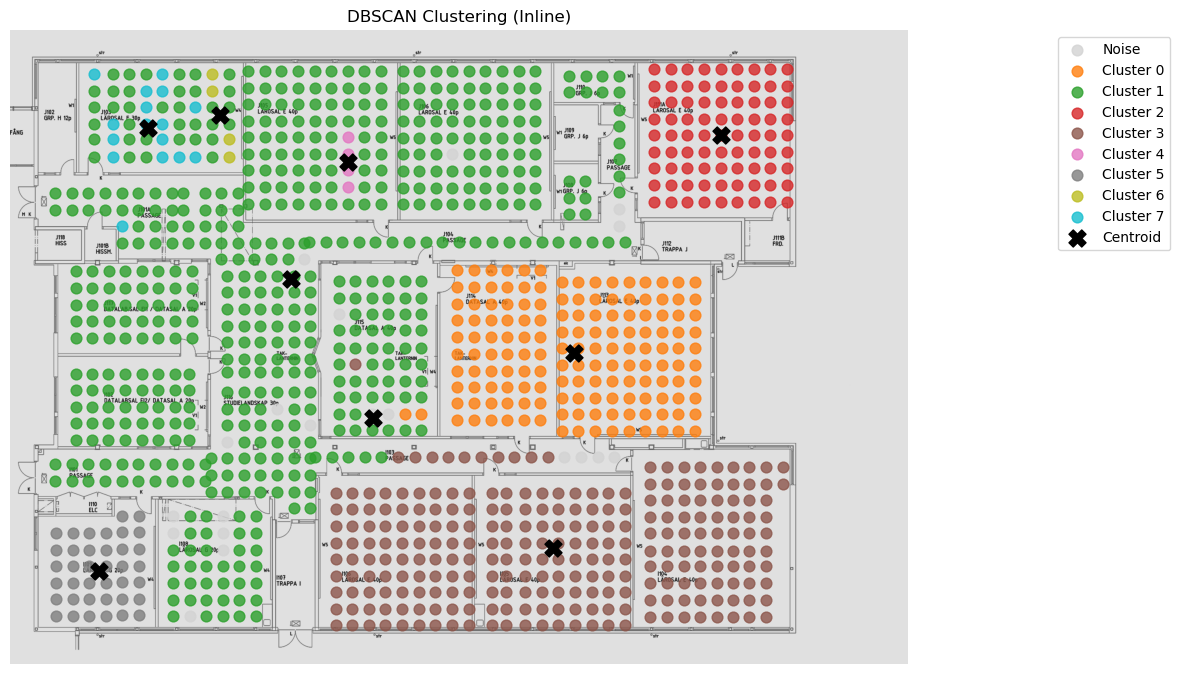

In [13]:
# --- DBSCAN ---
eps_values = [0.8, 1.0, 1.2, 1.6, 2.0, 2.5, 3.0]
best_sil, best_eps, best_labels, best_time = -1.0, None, None, 0.0
silhouette_scores = []

for eps in eps_values:
    start = time.time()
    labels = DBSCAN(eps=eps, min_samples=4).fit_predict(X)
    end = time.time()
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        s = silhouette_score(X, labels)
        silhouette_scores.append(s)
        if s > best_sil:
            best_sil, best_eps, best_labels, best_time = s, eps, labels, end - start
    else:
        silhouette_scores.append(-1.0)

if best_labels is None:
    best_eps = 1.0
    start = time.time()
    best_labels = DBSCAN(eps=best_eps, min_samples=4).fit_predict(X)
    end = time.time()
    best_time = end - start
    print("DBSCAN fallback to eps=1.0")
else:
    print(f"DBSCAN best eps={best_eps} with silhouette={best_sil:.4f}")

results.append({
    'Algorithm': 'DBSCAN',
    'Clusters': len(set(best_labels)) - (1 if -1 in best_labels else 0),
    'eps': best_eps,
    'Noise Points': int(np.sum(np.array(best_labels) == -1)),
    'Clustered Points': int(len(best_labels) - np.sum(np.array(best_labels) == -1)),
    'Clustering Time (s)': round(best_time, 4),
    'Silhouette Score': round(best_sil, 4)
})

df_train['cluster'] = best_labels
visualize_clusters_on_floorplan(df_train, "images/HV I-J Plan 1.png", f"DBSCAN Clustering (eps={best_eps})")
plot_clusters_inline(df_train, "images/HV I-J Plan 1.png", title="DBSCAN Clustering (Inline)")

In [14]:
# --- Display Final Results ---
results_df = pd.DataFrame(results)
order = ['Algorithm', 'Clusters', 'Clustering Time (s)', 'Silhouette Score']
if 'eps' in results_df.columns:
    order.append('eps')
if 'Noise Points' in results_df.columns:
    order += ['Noise Points', 'Clustered Points']
results_df = results_df[order]
print("\nClustering Algorithm Evaluation Results:")
print(results_df.to_string(index=False))


Clustering Algorithm Evaluation Results:
    Algorithm  Clusters  Clustering Time (s)  Silhouette Score  eps  Noise Points  Clustered Points
       KMeans        10               0.0664            0.4430  NaN           NaN               NaN
          GMM        19               0.0314            0.3913  NaN           NaN               NaN
Agglomerative        18               0.0355            0.4336  NaN           NaN               NaN
       DBSCAN         8               0.0214            0.1429  0.8          20.0            1111.0
